# 第4章　word2vecの高速化

前章のword2vecに二つの改良を加える。

1. Embeddingレイヤを導入

2. Negative Samplingという新しい損失関数を導入



## 4.1 word2vecの改良①

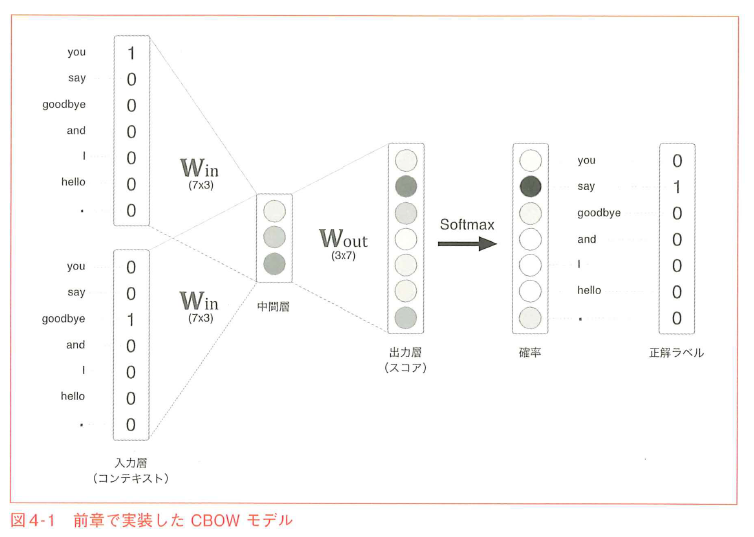

図4.1のCBOWモデルは小さなコーパスなら問題ない。巨大なコーパスの場合、いくつか問題が発生する。

図4.2は語彙数が100万、中間層が100のCBOWモデル。

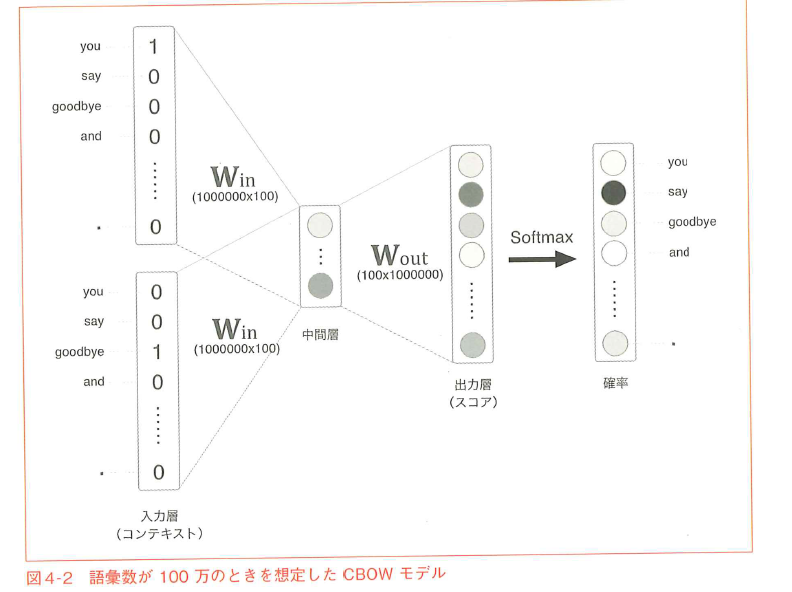

2か所の計算がボトルネックになる

- 入力層のone-hot表現と重み行列$W_{in}$の積の計算(4.1で解決）

- 中間層と重み行列$W_{out}$の積、およびSoftmaxレイヤの計算(4.2で解決）


### 4.1.1 Embeddingレイヤ

前章のword2vecでは単語をone-hot表現に変換しました。

語彙数が100万の場合のMatMulレイヤの計算が図4.3です。

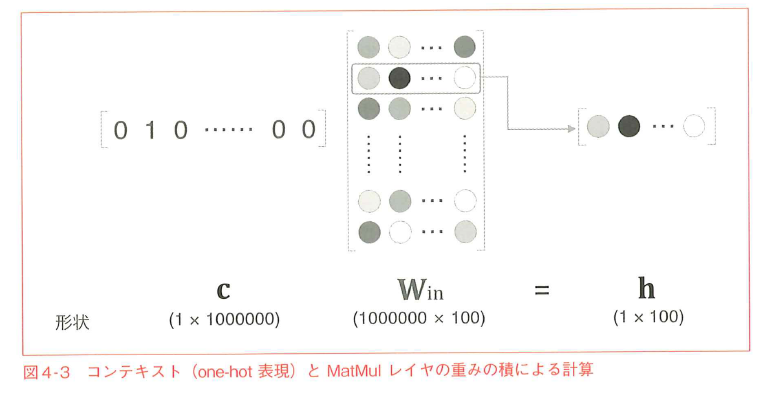

図4.3で行っているのは、行列の特定の行を抜き出すだけ。one-hot表現への変換とmatMulレイヤの乗算は不必要。

重みパラメータから「単語IDに相当する行(ベクトル)」を抜き出すレイヤを作成する。そのレイヤをEmbeddingレイヤと呼ぶ。

Embeddingとは単語の埋め込み(word embedding)という用語に由来

Embeddingレイヤに単語の埋め込み分散表現が格納される。

### 4.1.2 Embeddingレイヤの実装

行列から行を抜き出す処理は簡単。重み$W$が2次元配列の場合、$W[2]$,$W[5]$のように書くだけです。


In [1]:
import numpy as np
W=np.arange(21).reshape(7,3)
print(W)
print(W[2])
print(W[5])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
[6 7 8]
[15 16 17]


重み$W$から複数の行を取り出すのも簡単

配列によって、行番号を指定するだけ

In [2]:
idx=np.array([1,0,3,0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

では、Embeddingレイヤにforward()メソッドを実装します。

In [3]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        if GPU:
            np.scatter_add(dW, self.idx, dout)
        else:
            np.add.at(dW, self.idx, dout)
        return None

Embeddingの順伝播では、重み$W$の特定の行だけを抜き出すだけです。

逆伝搬では、前の層から伝わって来た勾配を入力層の特定の
行にそのまま流します。

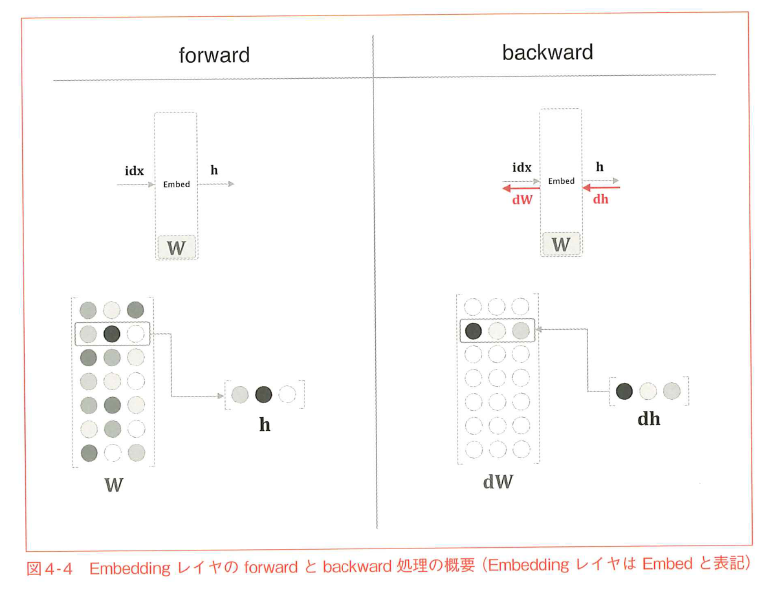

実装例です。

In [4]:
#悪い実装例
#def backward(self,dout):
#  dW,=self.grads
#  dW[...]=0
#  dW[self.idx]=dout
#  return None

この実装では、idxの要素が重複する場合に問題が発生します。

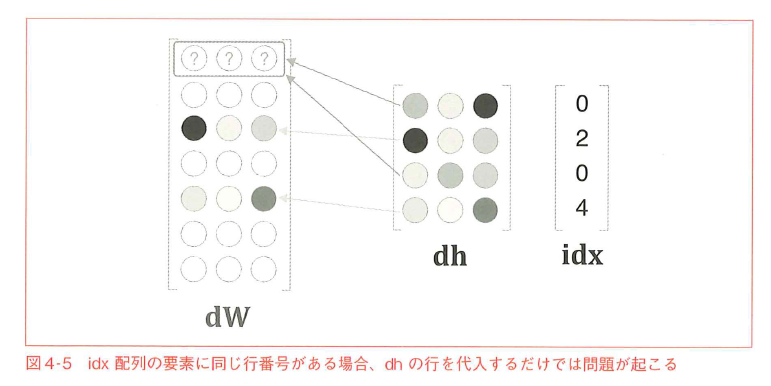

重複のある場合、「代入」ではなく「加算」を行う必要があります。

正しい実装は、

In [5]:
##正しいい実装例
#def backward(self,dout):
#  dW,=self.grads
#  dW[...]=0
#for i,word_id in enumerate(self.idx):
#  dW[word_id]+=dout[i]
##もしくは
#np.add.at(dW,self.idx,dout)
#  return None

以上でEmbeddingレイヤの実装は終わりです。これでword2vec（CBOWモデル）の実装では入力側のMatMulレイヤをEmbeddingレイヤに切り替えることができます。メモリの使用量を減らし、無駄な計算を省略できました。


## 4.2 word2vecの改良②

残るボトルネックは中間層以降の処理。行列の積とSoftmaxレイヤの計算です。そのためにNegative Sampling（負例サンプリング）と呼ばれる手法を使います。Softmaxの代わりにNegative Samplingを用いることで語彙数がどれだけ多くなっても計算量を一定に抑えることができます。


### 4.2.1 中間層以降の計算の問題点

語彙数が100万、中間層のニューロン数が100の場合のword2vec(CBOW
モデル)を考える。

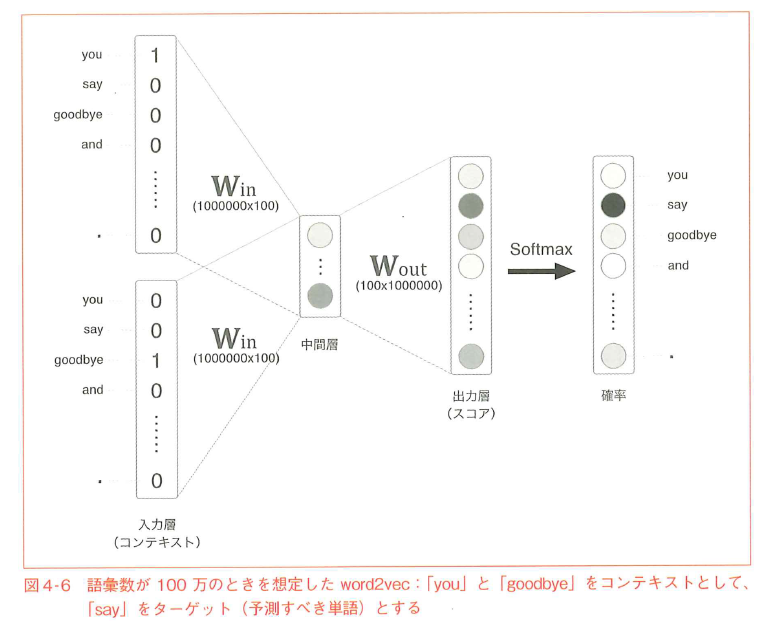

残っている計算のボトルネックは

1. 中間層のニューロンと重み$W_{out}$の積の計算

$W_{out}$のサイズは100×100万なので、順伝播も逆伝播も計算量が莫大

2. Softmaxレイヤの計算

$$
y_k=\frac{\exp(e_s)}{\sum_{i=1}^{10^6}\exp(s_i)}
$$






### 4.2.2 多値分類から二値分類へ

コンテキストを与えたときに、正解となる単語を高い確率で推測する。
("you","goodbye")に対して、正解である"say"の確率を高めるようにニューラルネットワークを学習

コンテキストが"you"と"goodbye"であるときに、正解が"say"ですか、という質問に答えるニューラルネットワークを考える。この場合、出力層は一つのニューロンでよい。出力層のニューロンは"say"であるスコアを出力する（図4.7）。










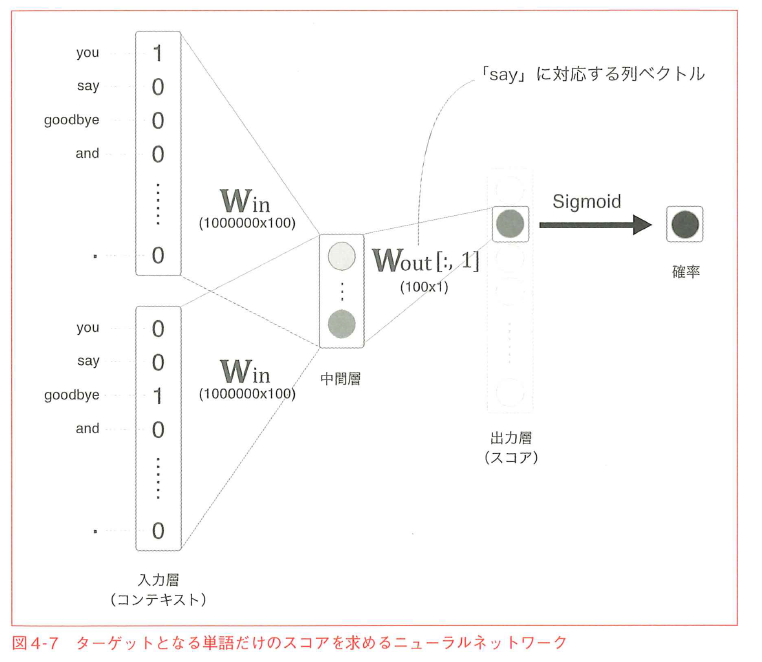

出力層のニューロンは一つなので、中間層と重み行列$W_{out}$の積は、"say"に対応する列＝単語ベクトルだけを抽出し、その抽出したベクトルと中間層のニューロンとの内積を計算すればよい（図4.8）。

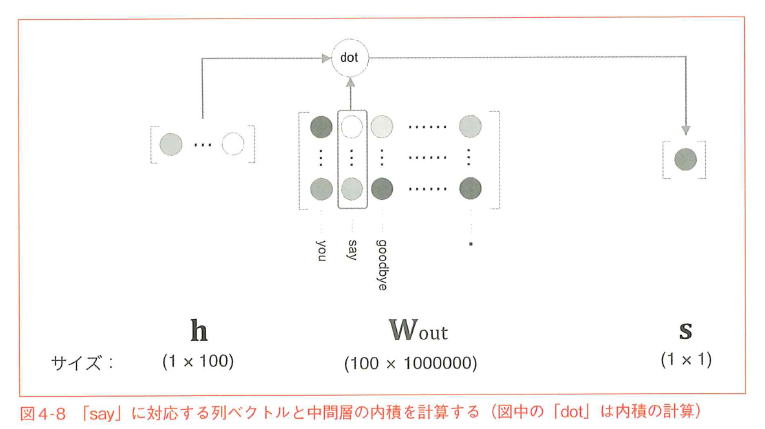

### 4.2.3 シグモイド関数と交差エントロピー誤差

スコアにシグモイド関数を適用し、確率を求め、交差エントロピー誤差を計算して損失とします。

シグモイド関数について復習です。

$$
y=\frac{1}{1+\exp(-x)}
$$

グラフは図4.9の右図のようになります。グラフの形状はS字カーブを描き、入力された値$x$を０から１の間の実数$y\in [0,1]$に変換します。シグモイド関数の出力は確率として解釈が可能です。

図4.9の左図はSigmoidレイヤです。


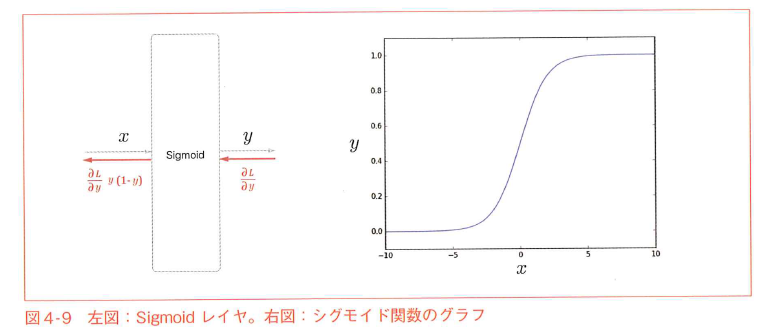

シグモイド関数で確率$y$を損失$L$に変換します。$t$で正解ラベルを表すとします。

$$
L=-(t\log y+(1-t)\log(1-t))
$$

図4.10はSigmoidレイヤとCross Entropyレイヤです。


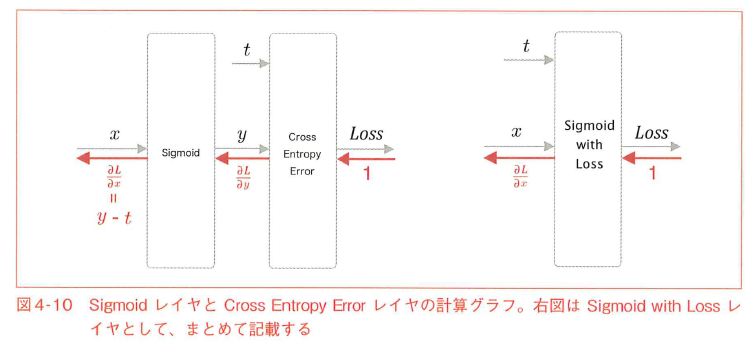

図4.10で注目すべき点は逆伝播の$y-t$という値です。

$y$はニューラルネットワークが出力した確率の値、$t$は正解ラベルです。

$t=1$の場合、$y$が$0$に近いと、$y-t$は負で絶対値の大きな値となり、$x$を増やすと損失は大きく減少します。$y$が$1$に近い場合、$y-t$は負の絶対値が小さな値なので$x$を増やしても損失の減少は小さいです。どちらにせよ、$x$を
増やすことで$y$を$t=1$に近づけます。$t=0$の場合は逆に$x$を減らすことで$y$を$t=0$に近づけ損失を減らします。

### 4.2.4 多値分類から二値分類へ（実装編）

多値分類では出力層に語彙数と等しい数のニューロンを用意し、Softmaxレイヤに通して損失を計算しました(図4.11)。

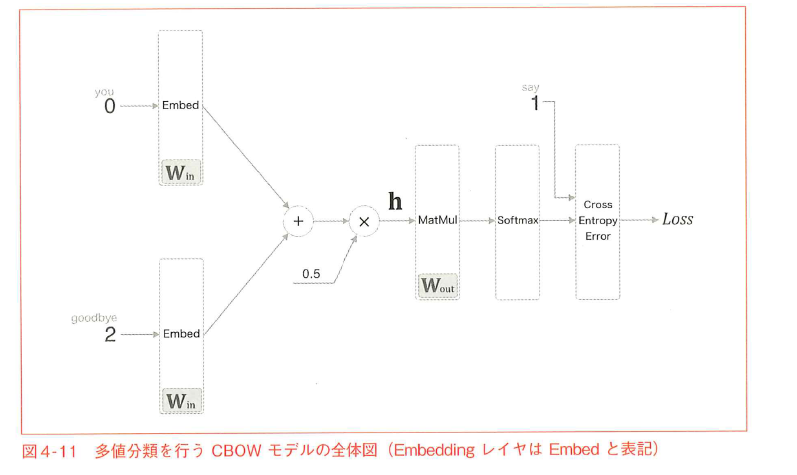

図4.11のニューラルネットワークを二値分類を行うネットワークに変換します(図4.12)。

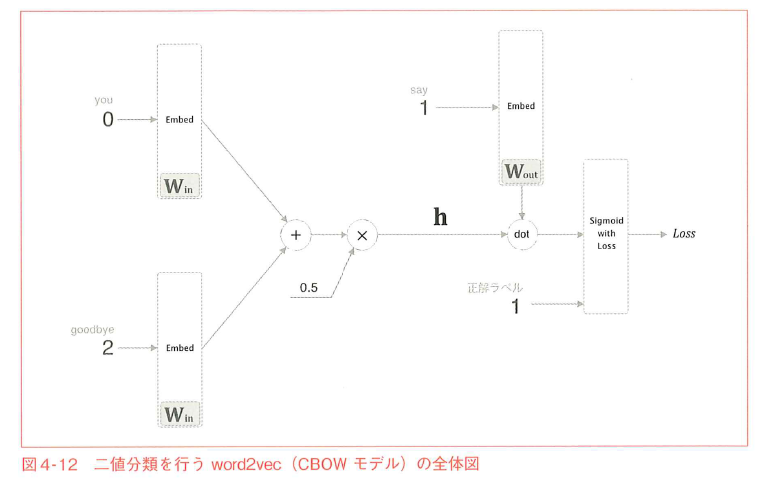

中間層のニューロンを$\vec{h}^T$とし、出力側の重み$W_{out}$のうち、
"say"に対応する列の単語ベクトルとの内積を計算します。そして、Sigmoid with Lossレイヤに入力し、損失を計算します。

図4.12の後半をシンプルにします。そのためにEmbedding Dotレイヤを導入します（図4.13）。Embeddingレイヤとdot演算（内積）の２つの処理を合わせたレイヤです。

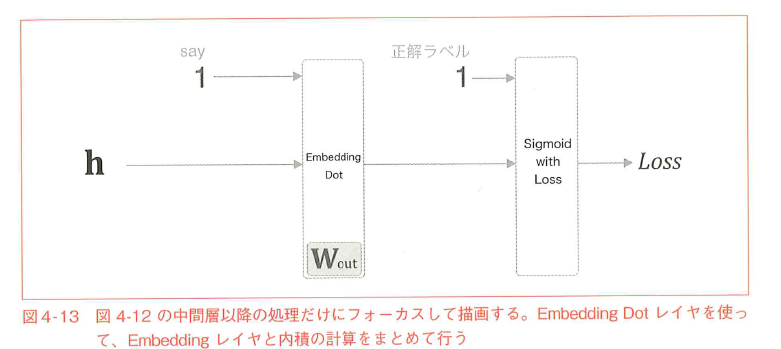

Embedding Dotレイヤを実装します。

In [6]:
import numpy as np

class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

Embeddingクラスには4つのメンバ変数-embed,params,grads,cacheがあります。cacheは順伝播のときに計算した結果を一時的に保持するためのものです。

- forward(h,idx)メソッドでは、引数に中間層のニューロン(h)と単語IDのNumpy配列(idx)を受け取ります。ミニバッチ処理を想定しています。

- forward()メソッドでは、Embeddingレイヤのforward(idx)を呼び、続いて内積の計算を行います。図4.14が計算例です。



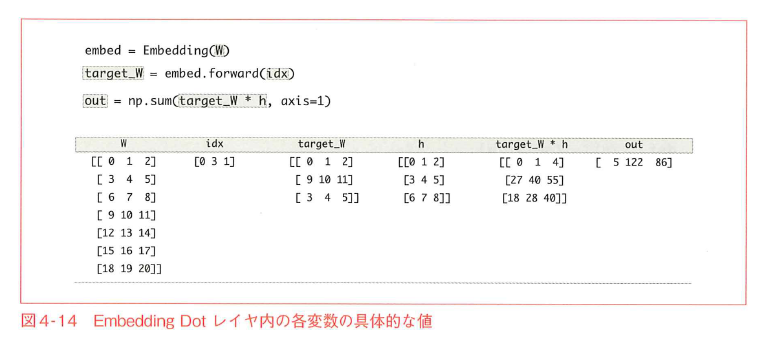

- 適当なW,idx,hを用意します。

- idx=[0 3 1]ですが、3つのデータに対する計算をミニバッチにしています。

- idx=[0 3 1]なので、target_WはWの0番、3番、1番の行を抜き出します。

- target_W*hで要素ごとに積を計算します。

- np.sum(target_W,*h,axis=1)で、行ごとに和を計算します。


In [7]:
class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

### 4.2.5 Negative Sampling

これまでは多値分類を二値分類とし、正解（正例）についてのみ学習してきました。（図4.15）

一方、誤った答え（負例）については学習していません。




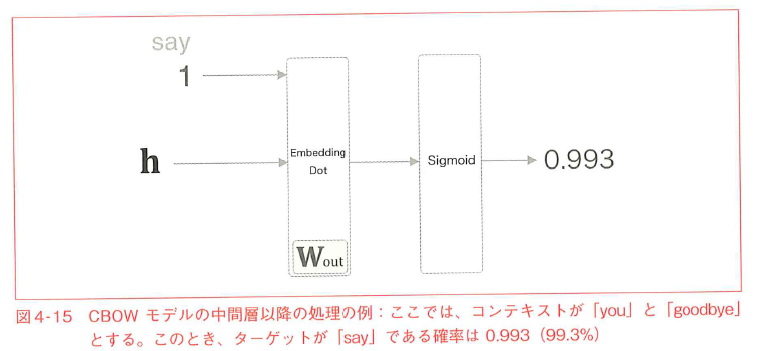


正例に対しては確率を1に近づけ、負例については確率を0に近づけることが
必要です（図4.16）。

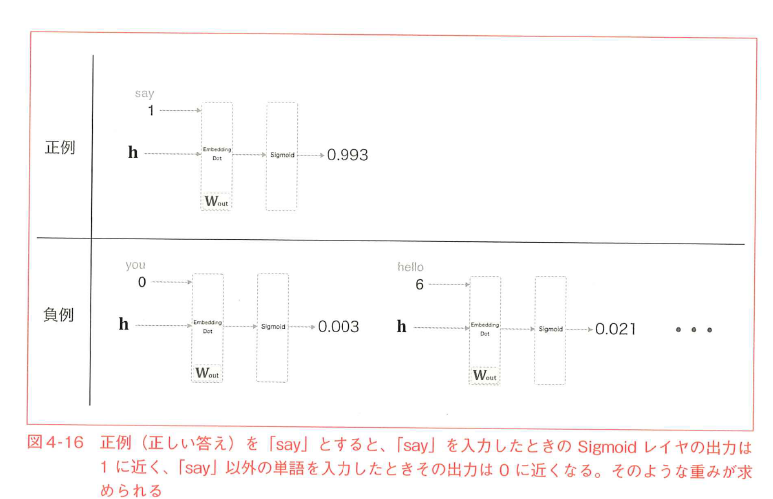

しかし、すべての負例について二値分類を行うことはしません。

近似的に、いくつかの負例をピックアップして学習します。

ネガティブな例（負例）を小数サンプリングして用いることを"Negative sampling"という手法の意味です。

Negative samplingの計算グラフは図4.17のようになります。



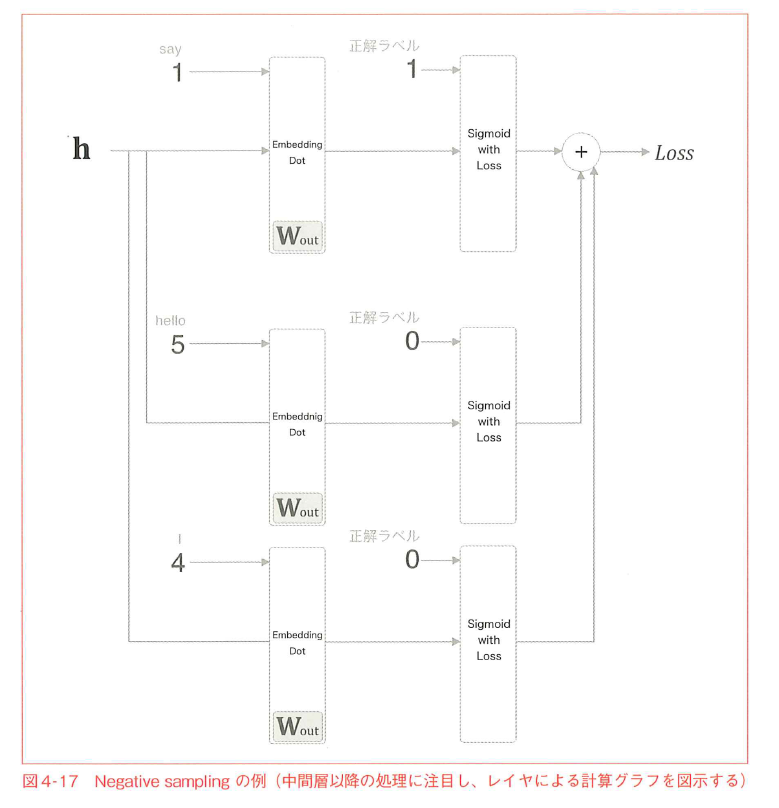

正例については、Sigmoid with Lossレイヤに正解ラベル1を入力します。

負例については、Sigmoid with Lossレイヤに正解ラベル0を入力します。

それぞれのデータに対する損失を足し合わせて最終的な損失を出力します。

### 4.2.6 Negative Samplingのサンプリング手法

負例をどのようにサンプリングするのか？ランダムサンプリングではなく、コーパスの統計データに基づいて、使用頻度に比例してサンプリングします。コーパスから各単語の出現回数を求めて確率分布で表し、その確率分布から単語をサンプリングします(図4.18)。




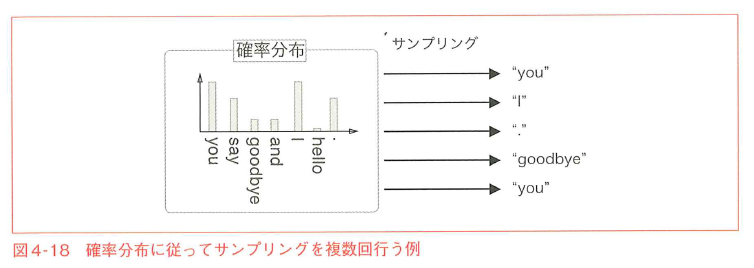

確率分布に従ってサンプリングするには、NumPyのnp.random.choice()メソッドを使います。ここでは、その使い方を示すため、いくつかの使用例を示します。

In [8]:
import numpy as np
# ０から９の数字からひとつの数字をランダムにサンプリング
np.random.choice(10),np.random.choice(10)

(8, 6)

In [9]:
#wordsからひとつだけランダムにサンプリング
words=["you","say","goodbye","I","hello","."]
np.random.choice(words)

'I'

In [10]:
#5つだけランダムにサンプリング（重複アリ)
np.random.choice(words,size=5)

array(['goodbye', 'I', '.', 'goodbye', '.'], dtype='<U7')

In [11]:
#5つだけランダムにサンプリング（重複なし)
np.random.choice(words,size=5,replace=False)

array(['.', 'I', 'say', 'hello', 'goodbye'], dtype='<U7')

In [12]:
#確率分布に従ってサンプリング
p=[0.5,0.1,0.05,0.2,0.05,0.1]
np.random.choice(words,size=10,p=p)

array(['you', 'you', 'you', 'say', 'you', 'you', 'say', 'you', 'you', 'I'],
      dtype='<U7')

word2vecで提案されたNegative samplingでは、確率分布に対して0.75を累乗して確率分布とし、サンプリングします。

$$
P'(w_i)=\frac{P(w_i)^{0.75}}{\sum_{j}P(w_j)^{0.75}}
$$

この変換は出現確率の低い単語を見捨てないようにするためです。0.75乗することで、確率の低い単語の確立を少しだけ高くします。


In [13]:
p=[0.7,0.29,0.01]
new_p=np.power(p,0.75)
new_p=new_p/np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


この処理を行うクラスをUnigramSamplerクラスで実装します。

In [14]:
import collections

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample


UnigramSamplerクラスは初期化の際に3つの引数を取ります。

1.単語IDのリストcorpus

2.確率分布に対する累乗のpower

3.負例サンプリングを行う個数のsample_size

UnigramSamplerクラスはget_negative_sample(target)というメッソドを持ちます。targetで指定したものを正例とし、それ以外の単語ＩＤのサンプリングを行います。



In [15]:
corpus=np.array([0,1,2,3,4,1,2,3])
power=0.75
sample_size=2
GPU=False

sampler=UnigramSampler(corpus,power,sample_size)
target=np.array([1,3,0])
negative_sample=sampler.get_negative_sample(target)
print(negative_sample)

[[3 2]
 [1 2]
 [1 2]]


### 4.2.7 Negative Samplingの実装

NegativeSamplingClassというクラスを実装します。

In [16]:
import collections

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

まずはイニシャライザから説明します。

```
# これはコードとして書式設定されます
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

```

初期化での引数は出力側の重みの$W$,コーパスcorpus(単語IDのリスト),確率分布の累乗の値power,負例サンプルの個数のsample_sizeです。

UnigramSamplerクラスを生成し、メンバ変数のsamplerで保持します。

負例サンプル数をメンバ変数のsample_sizeに格納します。

メンバ変数のloss_layerとembed_dot_layersには、必要なレイヤをリストで保持します。sample_size+1個のレイヤを生成し、正例用のレイヤを1個、負例用のレイヤをsample_size個とします。リストの最初のレイヤ(loss_layer[0],embed_dot_layers[0])が正例を扱うものとします。

後は、このレイヤで使用するパラメータと勾配を配列にまとめます。

順伝播の実装です。


```
# これはコードとして書式設定されます

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss
```
forward(h,target)メソッドが受け取る引数は、中間層ニューロンhと、正例のターゲットを示すtargetです。

まず、self.sampleで負例サンプリングを行い、negative_sampleとします。

後は、正例と負例のそれぞれに順伝播を行い、損失を加算します。EmbeddingDotレイヤのforwardでスコアを出力し、Sigmoid with Lossレイヤにインプットして損失を求めます。正例の場合は１，負例の場合は0の正解ラベルを入力します。




逆伝播の実装です。



```
# これはコードとして書式設定されます

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh
```

順伝播のときと逆順に各レイヤのbackword()を呼ぶだけです。

中間層のニューロンは順伝播のときに複数にコピーされました。Repeatノードに相当します。そのため逆伝播では、複数の勾配の加算となります。






## 4.3 改良版word2vecの学習

### 4.3.1 CBOWモデルの実装

前章のSimpleCBOWクラスを改良します。改良点はEmbeddingレイヤとNegative Sampling Lossレイヤを使うことです。さらにコンテキストとして任意のウィンドウサイズを使えるようにします。

改良版のCBOWクラスです。


In [17]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

まずイニシャライザです。


```
# これはコードとして書式設定されます
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
```


イニシャライザでは4つの引数を受け取ります。

vocab_size:語彙数、hidden_size:中間層のニューロン数,corpus:単語IDのリスト,window_size:コンテキストのサイズ

注意：改良前のSimpleCBOWクラスでは入力側の重みと出力側の重みの形状は異なり、出力側では列方向に単語ベクトルが格納されていました。CBOWクラでは、出力側の重みは入力側の重みと同じ形状で、行方向に単語ベクトルが配置されています。NegativeSamplingLossクラス内でEmbeddingレイヤを使用するためです。

重みの初期化後、レイヤを生成します。Embeddingレイヤを2*window_size個作成し、それをメンバ変数のin_layersに配列で保持します。そしてNegativeSamplingLossレイヤを生成します。

レイヤの作成後、パラメータと工場をparamsとgradsにまとめます。また、後ほど、単語の分散表現にアクセスできるよう、メンバ変数のword_vecsに重み$W_{in}$を設定します。





続いてforward()メソッドとbackward()メソッドです。



```
# これはコードとして書式設定されます
def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None
```


各レイヤの順伝播（もしくは逆伝播）を適切な順番で呼ぶだけです。

前章のSimpleCBOWの自然な拡張ですが、forward(contexts,target)メソッド
では、引数は単語IDから構成されます。SimpleCBOWではone-hotベクトルでした（図4.19）。






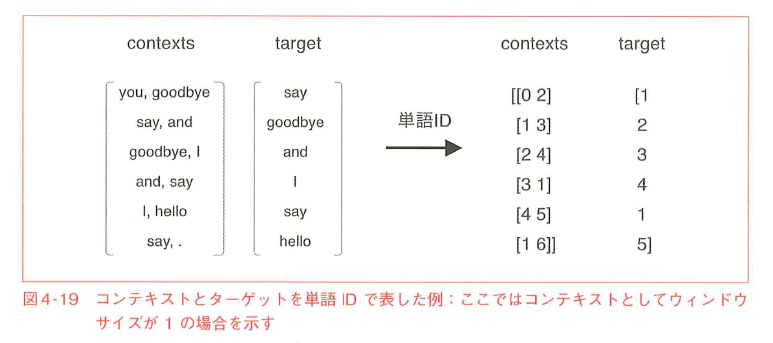

図4.19の右に示す単語IDの配列がcontextsとtargetの例です。

### 4.3.2 CBOWモデルの学習コード

CBOWモデルの学習を実装します。単にニューラルネットワークの学習を行うだけです。

In [18]:
import sys
import os
sys.path.append('..')

try:
    import urllib.request
except ImportError:
    raise ImportError('Use Python3!')
import pickle
import numpy as np

url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train':'ptb.train.txt',
    'test':'ptb.test.txt',
    'valid':'ptb.valid.txt'
}
save_file = {
    'train':'ptb.train.npy',
    'test':'ptb.test.npy',
    'valid':'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'

dataset_dir = os.path.dirname(os.path.abspath('__file__'))


def _download(file_name):
    file_path = dataset_dir + '/' + file_name
    if os.path.exists(file_path):
        return

    print('Downloading ' + file_name + ' ... ')

    try:
        urllib.request.urlretrieve(url_base + file_name, file_path)
    except urllib.error.URLError:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(url_base + file_name, file_path)

    print('Done')


def load_vocab():
    vocab_path = dataset_dir + '/' + vocab_file

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name

    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word


def load_data(data_type='train'):
    '''
        :param data_type: データの種類：'train' or 'test' or 'valid (val)'
        :return:
    '''
    if data_type == 'val': data_type = 'valid'
    save_path = dataset_dir + '/' + save_file[data_type]

    word_to_id, id_to_word = load_vocab()

    if os.path.exists(save_path):
        corpus = np.load(save_path)
        return corpus, word_to_id, id_to_word

    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name
    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()
    corpus = np.array([word_to_id[w] for w in words])

    np.save(save_path, corpus)
    return corpus, word_to_id, id_to_word

In [19]:
corpus, word_to_id, id_to_word = load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]', id_to_word[0])
print('id_to_word[1]', id_to_word[1])
print('id_to_word[2]', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0] aer
id_to_word[1] banknote
id_to_word[2] berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [20]:
import time
import matplotlib.pyplot as plt
import collections
import numpy
# GPUで実行する場合は、下記のコメントアウトを消去（要cupy）
# ===============================================
#GPU = True
GPU=False
if GPU:
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)

    print('\033[92m' + '-' * 60 + '\033[0m')
    print(' ' * 23 + '\033[92mGPU Mode (cupy)\033[0m')
    print('\033[92m' + '-' * 60 + '\033[0m\n')
else:
    import numpy as np
# ===============================================

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()


def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads



class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])

            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)


class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # レイヤの生成
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None


def create_contexts_target(corpus, window_size=1):
    '''コンテキストとターゲットの作成

    :param corpus: コーパス（単語IDのリスト）
    :param window_size: ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)


def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)

class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        if GPU:
            np.scatter_add(dW, self.idx, dout)
        else:
            np.add.at(dW, self.idx, dout)
        return None

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None


class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 1[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 2[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 3[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 5[s] | loss 4.04
| epoch 1 |  iter 101 / 9295 | time 6[s] | loss 3.92
| epoch 1 |  iter 121 / 9295 | time 7[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 8[s] | loss 3.63
| epoch 1 |  iter 161 / 9295 | time 9[s] | loss 3.49
| epoch 1 |  iter 181 / 9295 | time 11[s] | loss 3.37
| epoch 1 |  iter 201 / 9295 | time 12[s] | loss 3.25
| epoch 1 |  iter 221 / 9295 | time 13[s] | loss 3.18
| epoch 1 |  iter 241 / 9295 | time 14[s] | loss 3.10
| epoch 1 |  iter 261 / 9295 | time 15[s] | loss 3.02
| epoch 1 |  iter 281 / 9295 | time 17[s] | loss 2.96
| epoch 1 |  iter 301 / 9295 | time 18[s] | loss 2.91
| epoch 1 |  iter 321 / 9295 | time 19[s] | loss 2.86
| epoch 1 |  iter 341 / 9295 | time 20[s] | loss 2.86
| epoch 1 |  iter 361 / 9295 | time 22[s] |

| epoch 1 |  iter 2981 / 9295 | time 180[s] | loss 2.48
| epoch 1 |  iter 3001 / 9295 | time 181[s] | loss 2.44
| epoch 1 |  iter 3021 / 9295 | time 182[s] | loss 2.45
| epoch 1 |  iter 3041 / 9295 | time 183[s] | loss 2.43
| epoch 1 |  iter 3061 / 9295 | time 185[s] | loss 2.45
| epoch 1 |  iter 3081 / 9295 | time 186[s] | loss 2.46
| epoch 1 |  iter 3101 / 9295 | time 187[s] | loss 2.47
| epoch 1 |  iter 3121 / 9295 | time 188[s] | loss 2.42
| epoch 1 |  iter 3141 / 9295 | time 189[s] | loss 2.45
| epoch 1 |  iter 3161 / 9295 | time 191[s] | loss 2.42
| epoch 1 |  iter 3181 / 9295 | time 192[s] | loss 2.45
| epoch 1 |  iter 3201 / 9295 | time 193[s] | loss 2.45
| epoch 1 |  iter 3221 / 9295 | time 194[s] | loss 2.46
| epoch 1 |  iter 3241 / 9295 | time 195[s] | loss 2.49
| epoch 1 |  iter 3261 / 9295 | time 197[s] | loss 2.46
| epoch 1 |  iter 3281 / 9295 | time 198[s] | loss 2.45
| epoch 1 |  iter 3301 / 9295 | time 199[s] | loss 2.42
| epoch 1 |  iter 3321 / 9295 | time 200[s] | lo

| epoch 1 |  iter 5921 / 9295 | time 357[s] | loss 2.32
| epoch 1 |  iter 5941 / 9295 | time 358[s] | loss 2.33
| epoch 1 |  iter 5961 / 9295 | time 360[s] | loss 2.32
| epoch 1 |  iter 5981 / 9295 | time 361[s] | loss 2.35
| epoch 1 |  iter 6001 / 9295 | time 362[s] | loss 2.29
| epoch 1 |  iter 6021 / 9295 | time 363[s] | loss 2.29
| epoch 1 |  iter 6041 / 9295 | time 364[s] | loss 2.31
| epoch 1 |  iter 6061 / 9295 | time 366[s] | loss 2.33
| epoch 1 |  iter 6081 / 9295 | time 367[s] | loss 2.34
| epoch 1 |  iter 6101 / 9295 | time 368[s] | loss 2.31
| epoch 1 |  iter 6121 / 9295 | time 369[s] | loss 2.33
| epoch 1 |  iter 6141 / 9295 | time 370[s] | loss 2.33
| epoch 1 |  iter 6161 / 9295 | time 372[s] | loss 2.32
| epoch 1 |  iter 6181 / 9295 | time 373[s] | loss 2.33
| epoch 1 |  iter 6201 / 9295 | time 374[s] | loss 2.30
| epoch 1 |  iter 6221 / 9295 | time 375[s] | loss 2.33
| epoch 1 |  iter 6241 / 9295 | time 377[s] | loss 2.32
| epoch 1 |  iter 6261 / 9295 | time 378[s] | lo

| epoch 1 |  iter 8861 / 9295 | time 535[s] | loss 2.24
| epoch 1 |  iter 8881 / 9295 | time 537[s] | loss 2.21
| epoch 1 |  iter 8901 / 9295 | time 538[s] | loss 2.23
| epoch 1 |  iter 8921 / 9295 | time 539[s] | loss 2.23
| epoch 1 |  iter 8941 / 9295 | time 540[s] | loss 2.23
| epoch 1 |  iter 8961 / 9295 | time 541[s] | loss 2.25
| epoch 1 |  iter 8981 / 9295 | time 543[s] | loss 2.20
| epoch 1 |  iter 9001 / 9295 | time 544[s] | loss 2.22
| epoch 1 |  iter 9021 / 9295 | time 545[s] | loss 2.20
| epoch 1 |  iter 9041 / 9295 | time 546[s] | loss 2.23
| epoch 1 |  iter 9061 / 9295 | time 547[s] | loss 2.20
| epoch 1 |  iter 9081 / 9295 | time 549[s] | loss 2.20
| epoch 1 |  iter 9101 / 9295 | time 550[s] | loss 2.20
| epoch 1 |  iter 9121 / 9295 | time 551[s] | loss 2.25
| epoch 1 |  iter 9141 / 9295 | time 552[s] | loss 2.23
| epoch 1 |  iter 9161 / 9295 | time 554[s] | loss 2.25
| epoch 1 |  iter 9181 / 9295 | time 555[s] | loss 2.17
| epoch 1 |  iter 9201 / 9295 | time 556[s] | lo

| epoch 2 |  iter 2521 / 9295 | time 714[s] | loss 2.12
| epoch 2 |  iter 2541 / 9295 | time 715[s] | loss 2.10
| epoch 2 |  iter 2561 / 9295 | time 716[s] | loss 2.11
| epoch 2 |  iter 2581 / 9295 | time 717[s] | loss 2.14
| epoch 2 |  iter 2601 / 9295 | time 718[s] | loss 2.11
| epoch 2 |  iter 2621 / 9295 | time 720[s] | loss 2.14
| epoch 2 |  iter 2641 / 9295 | time 721[s] | loss 2.15
| epoch 2 |  iter 2661 / 9295 | time 722[s] | loss 2.13
| epoch 2 |  iter 2681 / 9295 | time 723[s] | loss 2.13
| epoch 2 |  iter 2701 / 9295 | time 724[s] | loss 2.11
| epoch 2 |  iter 2721 / 9295 | time 726[s] | loss 2.16
| epoch 2 |  iter 2741 / 9295 | time 727[s] | loss 2.14
| epoch 2 |  iter 2761 / 9295 | time 728[s] | loss 2.09
| epoch 2 |  iter 2781 / 9295 | time 729[s] | loss 2.12
| epoch 2 |  iter 2801 / 9295 | time 730[s] | loss 2.13
| epoch 2 |  iter 2821 / 9295 | time 732[s] | loss 2.11
| epoch 2 |  iter 2841 / 9295 | time 733[s] | loss 2.12
| epoch 2 |  iter 2861 / 9295 | time 734[s] | lo

| epoch 2 |  iter 5461 / 9295 | time 890[s] | loss 2.08
| epoch 2 |  iter 5481 / 9295 | time 891[s] | loss 2.07
| epoch 2 |  iter 5501 / 9295 | time 892[s] | loss 2.06
| epoch 2 |  iter 5521 / 9295 | time 894[s] | loss 2.07
| epoch 2 |  iter 5541 / 9295 | time 895[s] | loss 2.08
| epoch 2 |  iter 5561 / 9295 | time 896[s] | loss 2.05
| epoch 2 |  iter 5581 / 9295 | time 897[s] | loss 2.05
| epoch 2 |  iter 5601 / 9295 | time 898[s] | loss 2.06
| epoch 2 |  iter 5621 / 9295 | time 900[s] | loss 2.08
| epoch 2 |  iter 5641 / 9295 | time 901[s] | loss 2.07
| epoch 2 |  iter 5661 / 9295 | time 902[s] | loss 2.03
| epoch 2 |  iter 5681 / 9295 | time 903[s] | loss 2.09
| epoch 2 |  iter 5701 / 9295 | time 904[s] | loss 2.09
| epoch 2 |  iter 5721 / 9295 | time 906[s] | loss 2.08
| epoch 2 |  iter 5741 / 9295 | time 907[s] | loss 2.07
| epoch 2 |  iter 5761 / 9295 | time 908[s] | loss 2.11
| epoch 2 |  iter 5781 / 9295 | time 909[s] | loss 2.04
| epoch 2 |  iter 5801 / 9295 | time 910[s] | lo

| epoch 2 |  iter 8381 / 9295 | time 1065[s] | loss 2.02
| epoch 2 |  iter 8401 / 9295 | time 1067[s] | loss 1.99
| epoch 2 |  iter 8421 / 9295 | time 1068[s] | loss 1.98
| epoch 2 |  iter 8441 / 9295 | time 1069[s] | loss 2.00
| epoch 2 |  iter 8461 / 9295 | time 1070[s] | loss 2.01
| epoch 2 |  iter 8481 / 9295 | time 1071[s] | loss 2.03
| epoch 2 |  iter 8501 / 9295 | time 1073[s] | loss 2.01
| epoch 2 |  iter 8521 / 9295 | time 1074[s] | loss 2.03
| epoch 2 |  iter 8541 / 9295 | time 1075[s] | loss 2.04
| epoch 2 |  iter 8561 / 9295 | time 1076[s] | loss 2.05
| epoch 2 |  iter 8581 / 9295 | time 1077[s] | loss 2.02
| epoch 2 |  iter 8601 / 9295 | time 1079[s] | loss 1.99
| epoch 2 |  iter 8621 / 9295 | time 1080[s] | loss 2.01
| epoch 2 |  iter 8641 / 9295 | time 1081[s] | loss 2.00
| epoch 2 |  iter 8661 / 9295 | time 1082[s] | loss 1.99
| epoch 2 |  iter 8681 / 9295 | time 1083[s] | loss 2.00
| epoch 2 |  iter 8701 / 9295 | time 1085[s] | loss 1.99
| epoch 2 |  iter 8721 / 9295 |

| epoch 3 |  iter 1981 / 9295 | time 1240[s] | loss 1.91
| epoch 3 |  iter 2001 / 9295 | time 1241[s] | loss 1.96
| epoch 3 |  iter 2021 / 9295 | time 1243[s] | loss 1.93
| epoch 3 |  iter 2041 / 9295 | time 1244[s] | loss 1.94
| epoch 3 |  iter 2061 / 9295 | time 1245[s] | loss 1.89
| epoch 3 |  iter 2081 / 9295 | time 1246[s] | loss 1.92
| epoch 3 |  iter 2101 / 9295 | time 1247[s] | loss 1.95
| epoch 3 |  iter 2121 / 9295 | time 1249[s] | loss 1.92
| epoch 3 |  iter 2141 / 9295 | time 1250[s] | loss 1.91
| epoch 3 |  iter 2161 / 9295 | time 1251[s] | loss 1.89
| epoch 3 |  iter 2181 / 9295 | time 1252[s] | loss 1.89
| epoch 3 |  iter 2201 / 9295 | time 1253[s] | loss 1.94
| epoch 3 |  iter 2221 / 9295 | time 1255[s] | loss 1.94
| epoch 3 |  iter 2241 / 9295 | time 1256[s] | loss 1.92
| epoch 3 |  iter 2261 / 9295 | time 1257[s] | loss 1.93
| epoch 3 |  iter 2281 / 9295 | time 1258[s] | loss 1.93
| epoch 3 |  iter 2301 / 9295 | time 1259[s] | loss 1.96
| epoch 3 |  iter 2321 / 9295 |

| epoch 3 |  iter 4861 / 9295 | time 1414[s] | loss 1.91
| epoch 3 |  iter 4881 / 9295 | time 1415[s] | loss 1.93
| epoch 3 |  iter 4901 / 9295 | time 1416[s] | loss 1.92
| epoch 3 |  iter 4921 / 9295 | time 1417[s] | loss 1.91
| epoch 3 |  iter 4941 / 9295 | time 1419[s] | loss 1.96
| epoch 3 |  iter 4961 / 9295 | time 1420[s] | loss 1.93
| epoch 3 |  iter 4981 / 9295 | time 1421[s] | loss 1.89
| epoch 3 |  iter 5001 / 9295 | time 1422[s] | loss 1.86
| epoch 3 |  iter 5021 / 9295 | time 1423[s] | loss 1.91
| epoch 3 |  iter 5041 / 9295 | time 1425[s] | loss 1.92
| epoch 3 |  iter 5061 / 9295 | time 1426[s] | loss 1.95
| epoch 3 |  iter 5081 / 9295 | time 1427[s] | loss 1.91
| epoch 3 |  iter 5101 / 9295 | time 1428[s] | loss 1.94
| epoch 3 |  iter 5121 / 9295 | time 1429[s] | loss 1.91
| epoch 3 |  iter 5141 / 9295 | time 1431[s] | loss 1.93
| epoch 3 |  iter 5161 / 9295 | time 1432[s] | loss 1.91
| epoch 3 |  iter 5181 / 9295 | time 1433[s] | loss 1.91
| epoch 3 |  iter 5201 / 9295 |

| epoch 3 |  iter 7741 / 9295 | time 1586[s] | loss 1.90
| epoch 3 |  iter 7761 / 9295 | time 1587[s] | loss 1.89
| epoch 3 |  iter 7781 / 9295 | time 1588[s] | loss 1.90
| epoch 3 |  iter 7801 / 9295 | time 1589[s] | loss 1.88
| epoch 3 |  iter 7821 / 9295 | time 1591[s] | loss 1.90
| epoch 3 |  iter 7841 / 9295 | time 1592[s] | loss 1.90
| epoch 3 |  iter 7861 / 9295 | time 1593[s] | loss 1.91
| epoch 3 |  iter 7881 / 9295 | time 1594[s] | loss 1.91
| epoch 3 |  iter 7901 / 9295 | time 1595[s] | loss 1.88
| epoch 3 |  iter 7921 / 9295 | time 1597[s] | loss 1.89
| epoch 3 |  iter 7941 / 9295 | time 1598[s] | loss 1.86
| epoch 3 |  iter 7961 / 9295 | time 1599[s] | loss 1.89
| epoch 3 |  iter 7981 / 9295 | time 1600[s] | loss 1.92
| epoch 3 |  iter 8001 / 9295 | time 1601[s] | loss 1.91
| epoch 3 |  iter 8021 / 9295 | time 1603[s] | loss 1.88
| epoch 3 |  iter 8041 / 9295 | time 1604[s] | loss 1.88
| epoch 3 |  iter 8061 / 9295 | time 1605[s] | loss 1.87
| epoch 3 |  iter 8081 / 9295 |

| epoch 4 |  iter 1341 / 9295 | time 1760[s] | loss 1.82
| epoch 4 |  iter 1361 / 9295 | time 1761[s] | loss 1.83
| epoch 4 |  iter 1381 / 9295 | time 1763[s] | loss 1.82
| epoch 4 |  iter 1401 / 9295 | time 1764[s] | loss 1.77
| epoch 4 |  iter 1421 / 9295 | time 1765[s] | loss 1.82
| epoch 4 |  iter 1441 / 9295 | time 1766[s] | loss 1.83
| epoch 4 |  iter 1461 / 9295 | time 1767[s] | loss 1.79
| epoch 4 |  iter 1481 / 9295 | time 1769[s] | loss 1.84
| epoch 4 |  iter 1501 / 9295 | time 1770[s] | loss 1.82
| epoch 4 |  iter 1521 / 9295 | time 1771[s] | loss 1.80
| epoch 4 |  iter 1541 / 9295 | time 1772[s] | loss 1.84
| epoch 4 |  iter 1561 / 9295 | time 1773[s] | loss 1.84
| epoch 4 |  iter 1581 / 9295 | time 1775[s] | loss 1.83
| epoch 4 |  iter 1601 / 9295 | time 1776[s] | loss 1.84
| epoch 4 |  iter 1621 / 9295 | time 1777[s] | loss 1.82
| epoch 4 |  iter 1641 / 9295 | time 1778[s] | loss 1.84
| epoch 4 |  iter 1661 / 9295 | time 1779[s] | loss 1.82
| epoch 4 |  iter 1681 / 9295 |

| epoch 4 |  iter 4221 / 9295 | time 1933[s] | loss 1.76
| epoch 4 |  iter 4241 / 9295 | time 1934[s] | loss 1.78
| epoch 4 |  iter 4261 / 9295 | time 1936[s] | loss 1.79
| epoch 4 |  iter 4281 / 9295 | time 1937[s] | loss 1.84
| epoch 4 |  iter 4301 / 9295 | time 1938[s] | loss 1.78
| epoch 4 |  iter 4321 / 9295 | time 1939[s] | loss 1.78
| epoch 4 |  iter 4341 / 9295 | time 1940[s] | loss 1.81
| epoch 4 |  iter 4361 / 9295 | time 1942[s] | loss 1.78
| epoch 4 |  iter 4381 / 9295 | time 1943[s] | loss 1.84
| epoch 4 |  iter 4401 / 9295 | time 1944[s] | loss 1.85
| epoch 4 |  iter 4421 / 9295 | time 1945[s] | loss 1.75
| epoch 4 |  iter 4441 / 9295 | time 1946[s] | loss 1.77
| epoch 4 |  iter 4461 / 9295 | time 1948[s] | loss 1.78
| epoch 4 |  iter 4481 / 9295 | time 1949[s] | loss 1.82
| epoch 4 |  iter 4501 / 9295 | time 1950[s] | loss 1.83
| epoch 4 |  iter 4521 / 9295 | time 1951[s] | loss 1.83
| epoch 4 |  iter 4541 / 9295 | time 1952[s] | loss 1.83
| epoch 4 |  iter 4561 / 9295 |

| epoch 4 |  iter 7101 / 9295 | time 2106[s] | loss 1.77
| epoch 4 |  iter 7121 / 9295 | time 2107[s] | loss 1.80
| epoch 4 |  iter 7141 / 9295 | time 2108[s] | loss 1.81
| epoch 4 |  iter 7161 / 9295 | time 2109[s] | loss 1.78
| epoch 4 |  iter 7181 / 9295 | time 2111[s] | loss 1.79
| epoch 4 |  iter 7201 / 9295 | time 2112[s] | loss 1.80
| epoch 4 |  iter 7221 / 9295 | time 2113[s] | loss 1.83
| epoch 4 |  iter 7241 / 9295 | time 2114[s] | loss 1.79
| epoch 4 |  iter 7261 / 9295 | time 2115[s] | loss 1.81
| epoch 4 |  iter 7281 / 9295 | time 2117[s] | loss 1.80
| epoch 4 |  iter 7301 / 9295 | time 2118[s] | loss 1.81
| epoch 4 |  iter 7321 / 9295 | time 2119[s] | loss 1.82
| epoch 4 |  iter 7341 / 9295 | time 2120[s] | loss 1.79
| epoch 4 |  iter 7361 / 9295 | time 2121[s] | loss 1.82
| epoch 4 |  iter 7381 / 9295 | time 2122[s] | loss 1.82
| epoch 4 |  iter 7401 / 9295 | time 2124[s] | loss 1.81
| epoch 4 |  iter 7421 / 9295 | time 2125[s] | loss 1.78
| epoch 4 |  iter 7441 / 9295 |

| epoch 5 |  iter 701 / 9295 | time 2280[s] | loss 1.71
| epoch 5 |  iter 721 / 9295 | time 2281[s] | loss 1.71
| epoch 5 |  iter 741 / 9295 | time 2282[s] | loss 1.72
| epoch 5 |  iter 761 / 9295 | time 2283[s] | loss 1.73
| epoch 5 |  iter 781 / 9295 | time 2285[s] | loss 1.72
| epoch 5 |  iter 801 / 9295 | time 2286[s] | loss 1.73
| epoch 5 |  iter 821 / 9295 | time 2287[s] | loss 1.72
| epoch 5 |  iter 841 / 9295 | time 2288[s] | loss 1.67
| epoch 5 |  iter 861 / 9295 | time 2289[s] | loss 1.73
| epoch 5 |  iter 881 / 9295 | time 2291[s] | loss 1.74
| epoch 5 |  iter 901 / 9295 | time 2292[s] | loss 1.69
| epoch 5 |  iter 921 / 9295 | time 2293[s] | loss 1.72
| epoch 5 |  iter 941 / 9295 | time 2294[s] | loss 1.71
| epoch 5 |  iter 961 / 9295 | time 2295[s] | loss 1.73
| epoch 5 |  iter 981 / 9295 | time 2297[s] | loss 1.71
| epoch 5 |  iter 1001 / 9295 | time 2298[s] | loss 1.71
| epoch 5 |  iter 1021 / 9295 | time 2299[s] | loss 1.73
| epoch 5 |  iter 1041 / 9295 | time 2300[s] |

| epoch 5 |  iter 3581 / 9295 | time 2453[s] | loss 1.69
| epoch 5 |  iter 3601 / 9295 | time 2454[s] | loss 1.74
| epoch 5 |  iter 3621 / 9295 | time 2455[s] | loss 1.73
| epoch 5 |  iter 3641 / 9295 | time 2456[s] | loss 1.72
| epoch 5 |  iter 3661 / 9295 | time 2457[s] | loss 1.73
| epoch 5 |  iter 3681 / 9295 | time 2459[s] | loss 1.73
| epoch 5 |  iter 3701 / 9295 | time 2460[s] | loss 1.71
| epoch 5 |  iter 3721 / 9295 | time 2461[s] | loss 1.73
| epoch 5 |  iter 3741 / 9295 | time 2462[s] | loss 1.74
| epoch 5 |  iter 3761 / 9295 | time 2463[s] | loss 1.70
| epoch 5 |  iter 3781 / 9295 | time 2465[s] | loss 1.70
| epoch 5 |  iter 3801 / 9295 | time 2466[s] | loss 1.70
| epoch 5 |  iter 3821 / 9295 | time 2467[s] | loss 1.72
| epoch 5 |  iter 3841 / 9295 | time 2468[s] | loss 1.73
| epoch 5 |  iter 3861 / 9295 | time 2469[s] | loss 1.67
| epoch 5 |  iter 3881 / 9295 | time 2470[s] | loss 1.72
| epoch 5 |  iter 3901 / 9295 | time 2472[s] | loss 1.72
| epoch 5 |  iter 3921 / 9295 |

| epoch 5 |  iter 6461 / 9295 | time 2625[s] | loss 1.67
| epoch 5 |  iter 6481 / 9295 | time 2626[s] | loss 1.74
| epoch 5 |  iter 6501 / 9295 | time 2628[s] | loss 1.70
| epoch 5 |  iter 6521 / 9295 | time 2629[s] | loss 1.67
| epoch 5 |  iter 6541 / 9295 | time 2630[s] | loss 1.71
| epoch 5 |  iter 6561 / 9295 | time 2631[s] | loss 1.73
| epoch 5 |  iter 6581 / 9295 | time 2632[s] | loss 1.72
| epoch 5 |  iter 6601 / 9295 | time 2634[s] | loss 1.72
| epoch 5 |  iter 6621 / 9295 | time 2635[s] | loss 1.70
| epoch 5 |  iter 6641 / 9295 | time 2636[s] | loss 1.72
| epoch 5 |  iter 6661 / 9295 | time 2637[s] | loss 1.71
| epoch 5 |  iter 6681 / 9295 | time 2638[s] | loss 1.70
| epoch 5 |  iter 6701 / 9295 | time 2639[s] | loss 1.73
| epoch 5 |  iter 6721 / 9295 | time 2641[s] | loss 1.73
| epoch 5 |  iter 6741 / 9295 | time 2642[s] | loss 1.70
| epoch 5 |  iter 6761 / 9295 | time 2643[s] | loss 1.73
| epoch 5 |  iter 6781 / 9295 | time 2644[s] | loss 1.73
| epoch 5 |  iter 6801 / 9295 |

| epoch 6 |  iter 41 / 9295 | time 2798[s] | loss 1.64
| epoch 6 |  iter 61 / 9295 | time 2799[s] | loss 1.61
| epoch 6 |  iter 81 / 9295 | time 2800[s] | loss 1.62
| epoch 6 |  iter 101 / 9295 | time 2802[s] | loss 1.65
| epoch 6 |  iter 121 / 9295 | time 2803[s] | loss 1.64
| epoch 6 |  iter 141 / 9295 | time 2804[s] | loss 1.61
| epoch 6 |  iter 161 / 9295 | time 2805[s] | loss 1.64
| epoch 6 |  iter 181 / 9295 | time 2806[s] | loss 1.65
| epoch 6 |  iter 201 / 9295 | time 2808[s] | loss 1.61
| epoch 6 |  iter 221 / 9295 | time 2809[s] | loss 1.66
| epoch 6 |  iter 241 / 9295 | time 2810[s] | loss 1.64
| epoch 6 |  iter 261 / 9295 | time 2811[s] | loss 1.63
| epoch 6 |  iter 281 / 9295 | time 2813[s] | loss 1.63
| epoch 6 |  iter 301 / 9295 | time 2814[s] | loss 1.59
| epoch 6 |  iter 321 / 9295 | time 2815[s] | loss 1.61
| epoch 6 |  iter 341 / 9295 | time 2816[s] | loss 1.63
| epoch 6 |  iter 361 / 9295 | time 2817[s] | loss 1.60
| epoch 6 |  iter 381 / 9295 | time 2819[s] | loss 

| epoch 6 |  iter 2941 / 9295 | time 2973[s] | loss 1.66
| epoch 6 |  iter 2961 / 9295 | time 2974[s] | loss 1.68
| epoch 6 |  iter 2981 / 9295 | time 2976[s] | loss 1.65
| epoch 6 |  iter 3001 / 9295 | time 2977[s] | loss 1.65
| epoch 6 |  iter 3021 / 9295 | time 2978[s] | loss 1.61
| epoch 6 |  iter 3041 / 9295 | time 2979[s] | loss 1.63
| epoch 6 |  iter 3061 / 9295 | time 2981[s] | loss 1.63
| epoch 6 |  iter 3081 / 9295 | time 2982[s] | loss 1.63
| epoch 6 |  iter 3101 / 9295 | time 2983[s] | loss 1.66
| epoch 6 |  iter 3121 / 9295 | time 2984[s] | loss 1.64
| epoch 6 |  iter 3141 / 9295 | time 2985[s] | loss 1.64
| epoch 6 |  iter 3161 / 9295 | time 2987[s] | loss 1.63
| epoch 6 |  iter 3181 / 9295 | time 2988[s] | loss 1.65
| epoch 6 |  iter 3201 / 9295 | time 2989[s] | loss 1.61
| epoch 6 |  iter 3221 / 9295 | time 2990[s] | loss 1.65
| epoch 6 |  iter 3241 / 9295 | time 2991[s] | loss 1.64
| epoch 6 |  iter 3261 / 9295 | time 2993[s] | loss 1.64
| epoch 6 |  iter 3281 / 9295 |

| epoch 6 |  iter 5821 / 9295 | time 3146[s] | loss 1.61
| epoch 6 |  iter 5841 / 9295 | time 3147[s] | loss 1.66
| epoch 6 |  iter 5861 / 9295 | time 3149[s] | loss 1.67
| epoch 6 |  iter 5881 / 9295 | time 3150[s] | loss 1.67
| epoch 6 |  iter 5901 / 9295 | time 3151[s] | loss 1.69
| epoch 6 |  iter 5921 / 9295 | time 3152[s] | loss 1.64
| epoch 6 |  iter 5941 / 9295 | time 3153[s] | loss 1.65
| epoch 6 |  iter 5961 / 9295 | time 3155[s] | loss 1.64
| epoch 6 |  iter 5981 / 9295 | time 3156[s] | loss 1.64
| epoch 6 |  iter 6001 / 9295 | time 3157[s] | loss 1.64
| epoch 6 |  iter 6021 / 9295 | time 3158[s] | loss 1.67
| epoch 6 |  iter 6041 / 9295 | time 3159[s] | loss 1.62
| epoch 6 |  iter 6061 / 9295 | time 3161[s] | loss 1.61
| epoch 6 |  iter 6081 / 9295 | time 3162[s] | loss 1.66
| epoch 6 |  iter 6101 / 9295 | time 3163[s] | loss 1.66
| epoch 6 |  iter 6121 / 9295 | time 3164[s] | loss 1.65
| epoch 6 |  iter 6141 / 9295 | time 3165[s] | loss 1.65
| epoch 6 |  iter 6161 / 9295 |

| epoch 6 |  iter 8701 / 9295 | time 3318[s] | loss 1.67
| epoch 6 |  iter 8721 / 9295 | time 3320[s] | loss 1.73
| epoch 6 |  iter 8741 / 9295 | time 3321[s] | loss 1.63
| epoch 6 |  iter 8761 / 9295 | time 3322[s] | loss 1.64
| epoch 6 |  iter 8781 / 9295 | time 3323[s] | loss 1.65
| epoch 6 |  iter 8801 / 9295 | time 3324[s] | loss 1.67
| epoch 6 |  iter 8821 / 9295 | time 3326[s] | loss 1.68
| epoch 6 |  iter 8841 / 9295 | time 3327[s] | loss 1.61
| epoch 6 |  iter 8861 / 9295 | time 3328[s] | loss 1.66
| epoch 6 |  iter 8881 / 9295 | time 3329[s] | loss 1.70
| epoch 6 |  iter 8901 / 9295 | time 3330[s] | loss 1.63
| epoch 6 |  iter 8921 / 9295 | time 3332[s] | loss 1.63
| epoch 6 |  iter 8941 / 9295 | time 3333[s] | loss 1.63
| epoch 6 |  iter 8961 / 9295 | time 3334[s] | loss 1.64
| epoch 6 |  iter 8981 / 9295 | time 3335[s] | loss 1.62
| epoch 6 |  iter 9001 / 9295 | time 3336[s] | loss 1.66
| epoch 6 |  iter 9021 / 9295 | time 3338[s] | loss 1.63
| epoch 6 |  iter 9041 / 9295 |

| epoch 7 |  iter 2301 / 9295 | time 3493[s] | loss 1.55
| epoch 7 |  iter 2321 / 9295 | time 3494[s] | loss 1.59
| epoch 7 |  iter 2341 / 9295 | time 3495[s] | loss 1.61
| epoch 7 |  iter 2361 / 9295 | time 3496[s] | loss 1.58
| epoch 7 |  iter 2381 / 9295 | time 3498[s] | loss 1.59
| epoch 7 |  iter 2401 / 9295 | time 3499[s] | loss 1.54
| epoch 7 |  iter 2421 / 9295 | time 3500[s] | loss 1.59
| epoch 7 |  iter 2441 / 9295 | time 3501[s] | loss 1.62
| epoch 7 |  iter 2461 / 9295 | time 3502[s] | loss 1.57
| epoch 7 |  iter 2481 / 9295 | time 3504[s] | loss 1.60
| epoch 7 |  iter 2501 / 9295 | time 3505[s] | loss 1.56
| epoch 7 |  iter 2521 / 9295 | time 3506[s] | loss 1.58
| epoch 7 |  iter 2541 / 9295 | time 3507[s] | loss 1.58
| epoch 7 |  iter 2561 / 9295 | time 3508[s] | loss 1.62
| epoch 7 |  iter 2581 / 9295 | time 3510[s] | loss 1.60
| epoch 7 |  iter 2601 / 9295 | time 3511[s] | loss 1.57
| epoch 7 |  iter 2621 / 9295 | time 3512[s] | loss 1.58
| epoch 7 |  iter 2641 / 9295 |

| epoch 7 |  iter 5181 / 9295 | time 3666[s] | loss 1.60
| epoch 7 |  iter 5201 / 9295 | time 3667[s] | loss 1.56
| epoch 7 |  iter 5221 / 9295 | time 3668[s] | loss 1.61
| epoch 7 |  iter 5241 / 9295 | time 3670[s] | loss 1.59
| epoch 7 |  iter 5261 / 9295 | time 3671[s] | loss 1.59
| epoch 7 |  iter 5281 / 9295 | time 3672[s] | loss 1.58
| epoch 7 |  iter 5301 / 9295 | time 3673[s] | loss 1.56
| epoch 7 |  iter 5321 / 9295 | time 3674[s] | loss 1.59
| epoch 7 |  iter 5341 / 9295 | time 3676[s] | loss 1.62
| epoch 7 |  iter 5361 / 9295 | time 3677[s] | loss 1.55
| epoch 7 |  iter 5381 / 9295 | time 3678[s] | loss 1.59
| epoch 7 |  iter 5401 / 9295 | time 3679[s] | loss 1.60
| epoch 7 |  iter 5421 / 9295 | time 3680[s] | loss 1.63
| epoch 7 |  iter 5441 / 9295 | time 3682[s] | loss 1.52
| epoch 7 |  iter 5461 / 9295 | time 3683[s] | loss 1.62
| epoch 7 |  iter 5481 / 9295 | time 3684[s] | loss 1.59
| epoch 7 |  iter 5501 / 9295 | time 3685[s] | loss 1.59
| epoch 7 |  iter 5521 / 9295 |

| epoch 7 |  iter 8061 / 9295 | time 3838[s] | loss 1.56
| epoch 7 |  iter 8081 / 9295 | time 3840[s] | loss 1.60
| epoch 7 |  iter 8101 / 9295 | time 3841[s] | loss 1.59
| epoch 7 |  iter 8121 / 9295 | time 3842[s] | loss 1.57
| epoch 7 |  iter 8141 / 9295 | time 3843[s] | loss 1.60
| epoch 7 |  iter 8161 / 9295 | time 3844[s] | loss 1.59
| epoch 7 |  iter 8181 / 9295 | time 3846[s] | loss 1.58
| epoch 7 |  iter 8201 / 9295 | time 3847[s] | loss 1.58
| epoch 7 |  iter 8221 / 9295 | time 3848[s] | loss 1.59
| epoch 7 |  iter 8241 / 9295 | time 3849[s] | loss 1.54
| epoch 7 |  iter 8261 / 9295 | time 3850[s] | loss 1.58
| epoch 7 |  iter 8281 / 9295 | time 3852[s] | loss 1.57
| epoch 7 |  iter 8301 / 9295 | time 3853[s] | loss 1.58
| epoch 7 |  iter 8321 / 9295 | time 3854[s] | loss 1.59
| epoch 7 |  iter 8341 / 9295 | time 3855[s] | loss 1.59
| epoch 7 |  iter 8361 / 9295 | time 3856[s] | loss 1.60
| epoch 7 |  iter 8381 / 9295 | time 3858[s] | loss 1.61
| epoch 7 |  iter 8401 / 9295 |

| epoch 8 |  iter 1661 / 9295 | time 4012[s] | loss 1.55
| epoch 8 |  iter 1681 / 9295 | time 4014[s] | loss 1.49
| epoch 8 |  iter 1701 / 9295 | time 4015[s] | loss 1.54
| epoch 8 |  iter 1721 / 9295 | time 4016[s] | loss 1.55
| epoch 8 |  iter 1741 / 9295 | time 4017[s] | loss 1.54
| epoch 8 |  iter 1761 / 9295 | time 4018[s] | loss 1.53
| epoch 8 |  iter 1781 / 9295 | time 4020[s] | loss 1.53
| epoch 8 |  iter 1801 / 9295 | time 4021[s] | loss 1.49
| epoch 8 |  iter 1821 / 9295 | time 4022[s] | loss 1.53
| epoch 8 |  iter 1841 / 9295 | time 4023[s] | loss 1.50
| epoch 8 |  iter 1861 / 9295 | time 4024[s] | loss 1.54
| epoch 8 |  iter 1881 / 9295 | time 4026[s] | loss 1.53
| epoch 8 |  iter 1901 / 9295 | time 4027[s] | loss 1.55
| epoch 8 |  iter 1921 / 9295 | time 4028[s] | loss 1.53
| epoch 8 |  iter 1941 / 9295 | time 4029[s] | loss 1.51
| epoch 8 |  iter 1961 / 9295 | time 4031[s] | loss 1.50
| epoch 8 |  iter 1981 / 9295 | time 4032[s] | loss 1.54
| epoch 8 |  iter 2001 / 9295 |

| epoch 8 |  iter 4541 / 9295 | time 4187[s] | loss 1.55
| epoch 8 |  iter 4561 / 9295 | time 4188[s] | loss 1.55
| epoch 8 |  iter 4581 / 9295 | time 4189[s] | loss 1.56
| epoch 8 |  iter 4601 / 9295 | time 4190[s] | loss 1.56
| epoch 8 |  iter 4621 / 9295 | time 4191[s] | loss 1.52
| epoch 8 |  iter 4641 / 9295 | time 4193[s] | loss 1.57
| epoch 8 |  iter 4661 / 9295 | time 4194[s] | loss 1.53
| epoch 8 |  iter 4681 / 9295 | time 4195[s] | loss 1.51
| epoch 8 |  iter 4701 / 9295 | time 4196[s] | loss 1.52
| epoch 8 |  iter 4721 / 9295 | time 4197[s] | loss 1.52
| epoch 8 |  iter 4741 / 9295 | time 4199[s] | loss 1.56
| epoch 8 |  iter 4761 / 9295 | time 4200[s] | loss 1.53
| epoch 8 |  iter 4781 / 9295 | time 4201[s] | loss 1.51
| epoch 8 |  iter 4801 / 9295 | time 4202[s] | loss 1.50
| epoch 8 |  iter 4821 / 9295 | time 4203[s] | loss 1.52
| epoch 8 |  iter 4841 / 9295 | time 4205[s] | loss 1.54
| epoch 8 |  iter 4861 / 9295 | time 4206[s] | loss 1.54
| epoch 8 |  iter 4881 / 9295 |

| epoch 8 |  iter 7421 / 9295 | time 4359[s] | loss 1.51
| epoch 8 |  iter 7441 / 9295 | time 4360[s] | loss 1.54
| epoch 8 |  iter 7461 / 9295 | time 4362[s] | loss 1.54
| epoch 8 |  iter 7481 / 9295 | time 4363[s] | loss 1.58
| epoch 8 |  iter 7501 / 9295 | time 4364[s] | loss 1.53
| epoch 8 |  iter 7521 / 9295 | time 4365[s] | loss 1.53
| epoch 8 |  iter 7541 / 9295 | time 4366[s] | loss 1.56
| epoch 8 |  iter 7561 / 9295 | time 4368[s] | loss 1.52
| epoch 8 |  iter 7581 / 9295 | time 4369[s] | loss 1.54
| epoch 8 |  iter 7601 / 9295 | time 4370[s] | loss 1.50
| epoch 8 |  iter 7621 / 9295 | time 4371[s] | loss 1.51
| epoch 8 |  iter 7641 / 9295 | time 4372[s] | loss 1.57
| epoch 8 |  iter 7661 / 9295 | time 4374[s] | loss 1.52
| epoch 8 |  iter 7681 / 9295 | time 4375[s] | loss 1.48
| epoch 8 |  iter 7701 / 9295 | time 4376[s] | loss 1.53
| epoch 8 |  iter 7721 / 9295 | time 4377[s] | loss 1.56
| epoch 8 |  iter 7741 / 9295 | time 4378[s] | loss 1.54
| epoch 8 |  iter 7761 / 9295 |

| epoch 9 |  iter 1021 / 9295 | time 4533[s] | loss 1.48
| epoch 9 |  iter 1041 / 9295 | time 4534[s] | loss 1.43
| epoch 9 |  iter 1061 / 9295 | time 4535[s] | loss 1.45
| epoch 9 |  iter 1081 / 9295 | time 4536[s] | loss 1.43
| epoch 9 |  iter 1101 / 9295 | time 4537[s] | loss 1.46
| epoch 9 |  iter 1121 / 9295 | time 4539[s] | loss 1.48
| epoch 9 |  iter 1141 / 9295 | time 4540[s] | loss 1.43
| epoch 9 |  iter 1161 / 9295 | time 4541[s] | loss 1.47
| epoch 9 |  iter 1181 / 9295 | time 4542[s] | loss 1.48
| epoch 9 |  iter 1201 / 9295 | time 4543[s] | loss 1.48
| epoch 9 |  iter 1221 / 9295 | time 4545[s] | loss 1.47
| epoch 9 |  iter 1241 / 9295 | time 4546[s] | loss 1.45
| epoch 9 |  iter 1261 / 9295 | time 4547[s] | loss 1.44
| epoch 9 |  iter 1281 / 9295 | time 4548[s] | loss 1.45
| epoch 9 |  iter 1301 / 9295 | time 4549[s] | loss 1.48
| epoch 9 |  iter 1321 / 9295 | time 4551[s] | loss 1.46
| epoch 9 |  iter 1341 / 9295 | time 4552[s] | loss 1.47
| epoch 9 |  iter 1361 / 9295 |

| epoch 9 |  iter 3901 / 9295 | time 4706[s] | loss 1.47
| epoch 9 |  iter 3921 / 9295 | time 4707[s] | loss 1.47
| epoch 9 |  iter 3941 / 9295 | time 4708[s] | loss 1.51
| epoch 9 |  iter 3961 / 9295 | time 4710[s] | loss 1.48
| epoch 9 |  iter 3981 / 9295 | time 4711[s] | loss 1.48
| epoch 9 |  iter 4001 / 9295 | time 4712[s] | loss 1.50
| epoch 9 |  iter 4021 / 9295 | time 4713[s] | loss 1.50
| epoch 9 |  iter 4041 / 9295 | time 4714[s] | loss 1.46
| epoch 9 |  iter 4061 / 9295 | time 4716[s] | loss 1.48
| epoch 9 |  iter 4081 / 9295 | time 4717[s] | loss 1.49
| epoch 9 |  iter 4101 / 9295 | time 4718[s] | loss 1.46
| epoch 9 |  iter 4121 / 9295 | time 4719[s] | loss 1.49
| epoch 9 |  iter 4141 / 9295 | time 4720[s] | loss 1.48
| epoch 9 |  iter 4161 / 9295 | time 4722[s] | loss 1.46
| epoch 9 |  iter 4181 / 9295 | time 4723[s] | loss 1.49
| epoch 9 |  iter 4201 / 9295 | time 4724[s] | loss 1.45
| epoch 9 |  iter 4221 / 9295 | time 4725[s] | loss 1.51
| epoch 9 |  iter 4241 / 9295 |

| epoch 9 |  iter 6781 / 9295 | time 4879[s] | loss 1.48
| epoch 9 |  iter 6801 / 9295 | time 4880[s] | loss 1.48
| epoch 9 |  iter 6821 / 9295 | time 4881[s] | loss 1.49
| epoch 9 |  iter 6841 / 9295 | time 4882[s] | loss 1.47
| epoch 9 |  iter 6861 / 9295 | time 4884[s] | loss 1.50
| epoch 9 |  iter 6881 / 9295 | time 4885[s] | loss 1.49
| epoch 9 |  iter 6901 / 9295 | time 4886[s] | loss 1.50
| epoch 9 |  iter 6921 / 9295 | time 4887[s] | loss 1.52
| epoch 9 |  iter 6941 / 9295 | time 4888[s] | loss 1.47
| epoch 9 |  iter 6961 / 9295 | time 4890[s] | loss 1.52
| epoch 9 |  iter 6981 / 9295 | time 4891[s] | loss 1.53
| epoch 9 |  iter 7001 / 9295 | time 4892[s] | loss 1.51
| epoch 9 |  iter 7021 / 9295 | time 4893[s] | loss 1.50
| epoch 9 |  iter 7041 / 9295 | time 4895[s] | loss 1.47
| epoch 9 |  iter 7061 / 9295 | time 4896[s] | loss 1.48
| epoch 9 |  iter 7081 / 9295 | time 4897[s] | loss 1.47
| epoch 9 |  iter 7101 / 9295 | time 4898[s] | loss 1.49
| epoch 9 |  iter 7121 / 9295 |

| epoch 10 |  iter 361 / 9295 | time 5053[s] | loss 1.45
| epoch 10 |  iter 381 / 9295 | time 5054[s] | loss 1.43
| epoch 10 |  iter 401 / 9295 | time 5055[s] | loss 1.40
| epoch 10 |  iter 421 / 9295 | time 5056[s] | loss 1.41
| epoch 10 |  iter 441 / 9295 | time 5057[s] | loss 1.45
| epoch 10 |  iter 461 / 9295 | time 5059[s] | loss 1.40
| epoch 10 |  iter 481 / 9295 | time 5060[s] | loss 1.38
| epoch 10 |  iter 501 / 9295 | time 5061[s] | loss 1.43
| epoch 10 |  iter 521 / 9295 | time 5062[s] | loss 1.41
| epoch 10 |  iter 541 / 9295 | time 5063[s] | loss 1.42
| epoch 10 |  iter 561 / 9295 | time 5065[s] | loss 1.40
| epoch 10 |  iter 581 / 9295 | time 5066[s] | loss 1.42
| epoch 10 |  iter 601 / 9295 | time 5067[s] | loss 1.44
| epoch 10 |  iter 621 / 9295 | time 5068[s] | loss 1.42
| epoch 10 |  iter 641 / 9295 | time 5069[s] | loss 1.45
| epoch 10 |  iter 661 / 9295 | time 5071[s] | loss 1.43
| epoch 10 |  iter 681 / 9295 | time 5072[s] | loss 1.46
| epoch 10 |  iter 701 / 9295 |

| epoch 10 |  iter 3201 / 9295 | time 5223[s] | loss 1.45
| epoch 10 |  iter 3221 / 9295 | time 5224[s] | loss 1.44
| epoch 10 |  iter 3241 / 9295 | time 5225[s] | loss 1.41
| epoch 10 |  iter 3261 / 9295 | time 5226[s] | loss 1.43
| epoch 10 |  iter 3281 / 9295 | time 5228[s] | loss 1.44
| epoch 10 |  iter 3301 / 9295 | time 5229[s] | loss 1.42
| epoch 10 |  iter 3321 / 9295 | time 5230[s] | loss 1.41
| epoch 10 |  iter 3341 / 9295 | time 5231[s] | loss 1.43
| epoch 10 |  iter 3361 / 9295 | time 5232[s] | loss 1.42
| epoch 10 |  iter 3381 / 9295 | time 5234[s] | loss 1.47
| epoch 10 |  iter 3401 / 9295 | time 5235[s] | loss 1.43
| epoch 10 |  iter 3421 / 9295 | time 5236[s] | loss 1.41
| epoch 10 |  iter 3441 / 9295 | time 5237[s] | loss 1.43
| epoch 10 |  iter 3461 / 9295 | time 5238[s] | loss 1.45
| epoch 10 |  iter 3481 / 9295 | time 5240[s] | loss 1.47
| epoch 10 |  iter 3501 / 9295 | time 5241[s] | loss 1.44
| epoch 10 |  iter 3521 / 9295 | time 5242[s] | loss 1.42
| epoch 10 |  

| epoch 10 |  iter 6041 / 9295 | time 5394[s] | loss 1.44
| epoch 10 |  iter 6061 / 9295 | time 5395[s] | loss 1.44
| epoch 10 |  iter 6081 / 9295 | time 5396[s] | loss 1.44
| epoch 10 |  iter 6101 / 9295 | time 5397[s] | loss 1.44
| epoch 10 |  iter 6121 / 9295 | time 5399[s] | loss 1.46
| epoch 10 |  iter 6141 / 9295 | time 5400[s] | loss 1.42
| epoch 10 |  iter 6161 / 9295 | time 5401[s] | loss 1.45
| epoch 10 |  iter 6181 / 9295 | time 5402[s] | loss 1.44
| epoch 10 |  iter 6201 / 9295 | time 5403[s] | loss 1.48
| epoch 10 |  iter 6221 / 9295 | time 5405[s] | loss 1.45
| epoch 10 |  iter 6241 / 9295 | time 5406[s] | loss 1.45
| epoch 10 |  iter 6261 / 9295 | time 5407[s] | loss 1.41
| epoch 10 |  iter 6281 / 9295 | time 5408[s] | loss 1.44
| epoch 10 |  iter 6301 / 9295 | time 5409[s] | loss 1.42
| epoch 10 |  iter 6321 / 9295 | time 5411[s] | loss 1.47
| epoch 10 |  iter 6341 / 9295 | time 5412[s] | loss 1.44
| epoch 10 |  iter 6361 / 9295 | time 5413[s] | loss 1.44
| epoch 10 |  

| epoch 10 |  iter 8881 / 9295 | time 5565[s] | loss 1.44
| epoch 10 |  iter 8901 / 9295 | time 5566[s] | loss 1.46
| epoch 10 |  iter 8921 / 9295 | time 5567[s] | loss 1.48
| epoch 10 |  iter 8941 / 9295 | time 5568[s] | loss 1.48
| epoch 10 |  iter 8961 / 9295 | time 5569[s] | loss 1.42
| epoch 10 |  iter 8981 / 9295 | time 5571[s] | loss 1.48
| epoch 10 |  iter 9001 / 9295 | time 5572[s] | loss 1.43
| epoch 10 |  iter 9021 / 9295 | time 5573[s] | loss 1.48
| epoch 10 |  iter 9041 / 9295 | time 5574[s] | loss 1.49
| epoch 10 |  iter 9061 / 9295 | time 5575[s] | loss 1.47
| epoch 10 |  iter 9081 / 9295 | time 5577[s] | loss 1.42
| epoch 10 |  iter 9101 / 9295 | time 5578[s] | loss 1.47
| epoch 10 |  iter 9121 / 9295 | time 5579[s] | loss 1.45
| epoch 10 |  iter 9141 / 9295 | time 5580[s] | loss 1.42
| epoch 10 |  iter 9161 / 9295 | time 5581[s] | loss 1.46
| epoch 10 |  iter 9181 / 9295 | time 5583[s] | loss 1.45
| epoch 10 |  iter 9201 / 9295 | time 5584[s] | loss 1.45
| epoch 10 |  

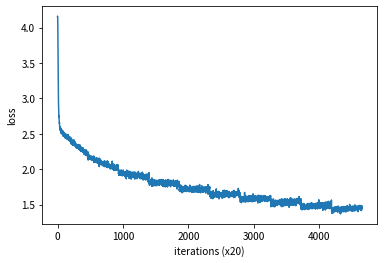

In [22]:
import pickle

# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

### 4.3.3 CBOWモデルの評価

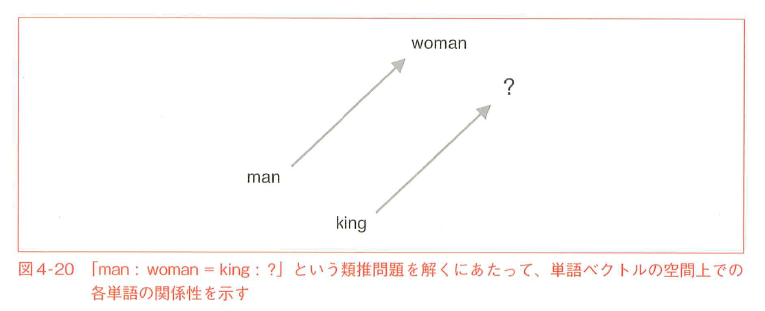

## 4.4 word2vecに関する残りのテーマ

### 4.4.1 word2vecを使ったアプリケーションの例

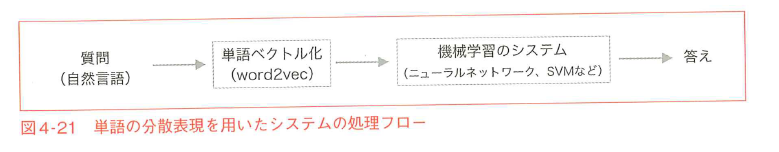

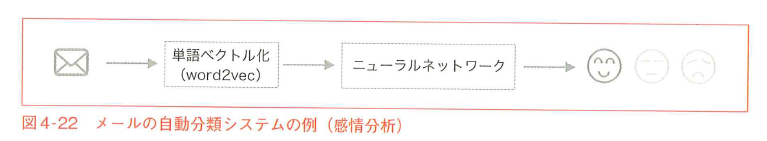

### 4.4.2 単語ベクトルの評価方法

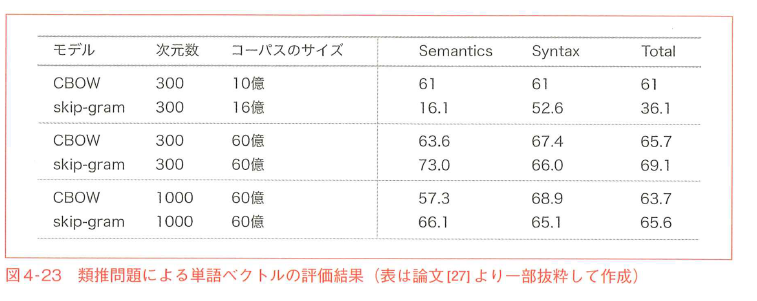

## 4.5 まとめ

本章ではword2vecの高速化をテーマに前章のCBOWモデルの改良を行いました。Embeddingレイヤを実装し、Negative Samplingという新しい手法を導入しました。

重要なポイントは、全体ではなく一部を処理することです。Negative Samplingはその考えに基づいています。

前章と本章でword2vecの解説は終わりです。word2vecによる単語の分散表現はさまざまな自然言語処理のタスクに利用さえれています。また、word2vecの思想は自然言語以外の他の分野(音声、画像、動画など)にも応用されています。



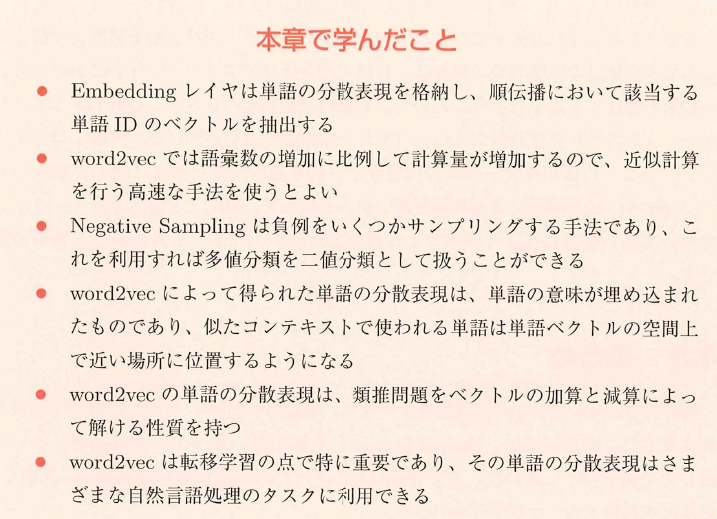